In [32]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

In [33]:
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

In [34]:
sys.path.append(os.path.abspath("../.."))


In [35]:
from analysis.preprocessing import (
    load_and_clean_plastic_waste_data,
    load_and_clean_plastic_production_data,
    load_and_clean_plastic_waste_ocean_data,
    load_and_clean_CO2_emission_data
)


In [36]:
df_plastic_waste = load_and_clean_plastic_waste_data()
df_plastic_production = load_and_clean_plastic_production_data()
df_plastic_waste_ocean = load_and_clean_plastic_waste_ocean_data()

# Chargement des données CO2
df_co2 = load_and_clean_CO2_emission_data()

print("Données chargées avec succès!")
print(f"Déchets plastiques: {df_plastic_waste.shape}")
print(f"Production plastique: {df_plastic_production.shape}")
print(f"Plastiques océan: {df_plastic_waste_ocean.shape}")
print(f"Émissions CO2: {df_co2.shape}")


Données chargées avec succès!
Déchets plastiques: (5012, 3)
Production plastique: (69, 4)
Plastiques océan: (170, 4)
Émissions CO2: (29384, 4)


In [37]:
co2_mondial = df_co2.groupby('Year')['emissions_total'].sum().reset_index()
co2_mondial = co2_mondial[co2_mondial['Year'] >= 1950]  # Filtrer à partir de 1950

production_mondiale = df_plastic_production.groupby('Year')['plastic_production'].sum().reset_index()

# Fusion des données
merged_temporal = co2_mondial.merge(production_mondiale, on='Year', how='inner')

print(f"Données temporelles fusionnées: {merged_temporal.shape}")
print(f"Période couverte: {merged_temporal['Year'].min()} - {merged_temporal['Year'].max()}")


Données temporelles fusionnées: (69, 3)
Période couverte: 1950 - 2019


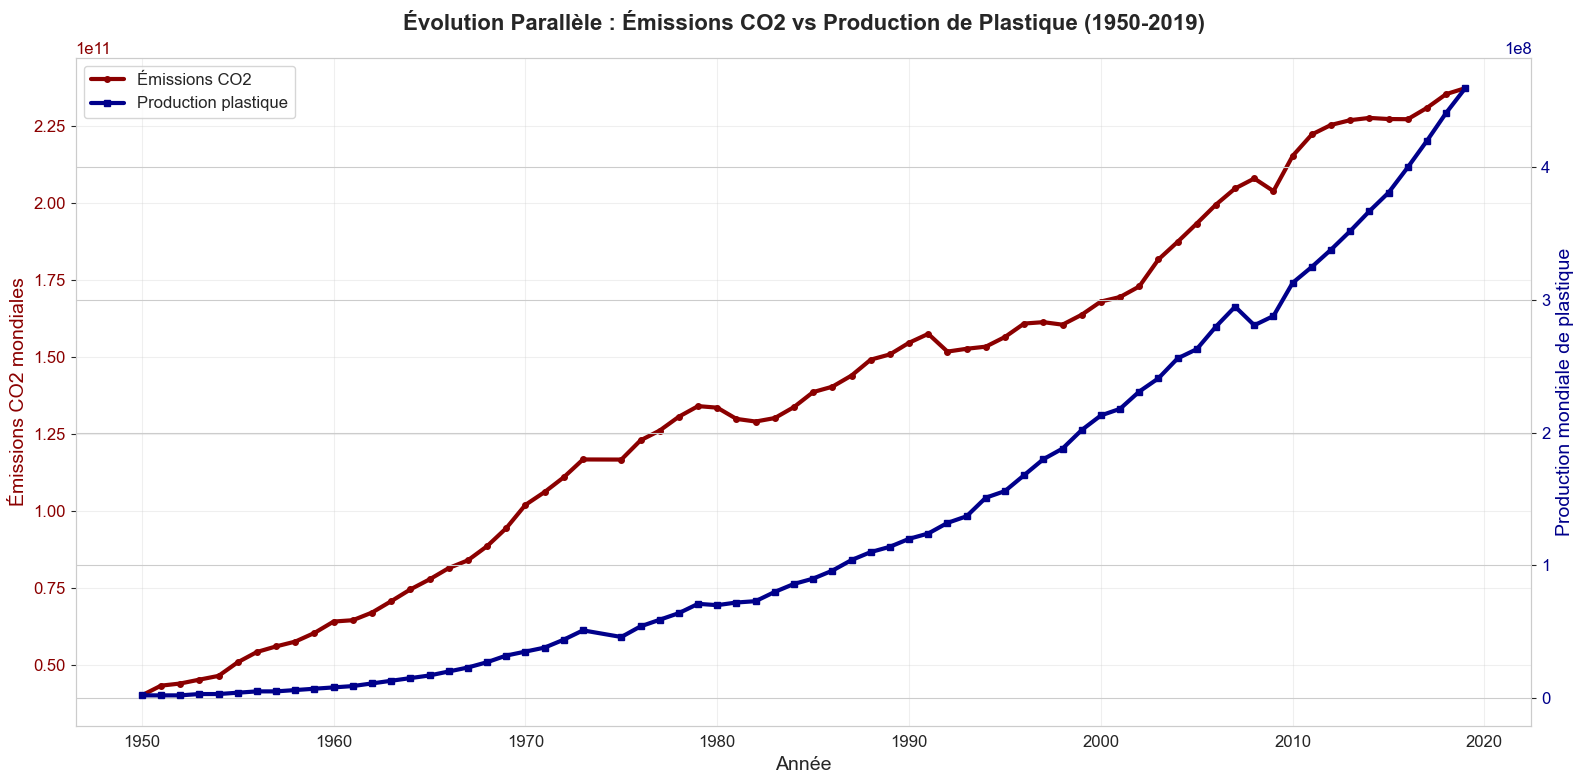


Corrélation entre CO2 et production plastique: 0.945 (p-value: 2.336e-34)


In [38]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color1 = 'darkred'
ax1.set_xlabel('Année', fontsize=14)
ax1.set_ylabel('Émissions CO2 mondiales', color=color1, fontsize=14)
line1 = ax1.plot(merged_temporal['Year'], merged_temporal['emissions_total'],
                 color=color1, linewidth=3, marker='o', markersize=4, label='Émissions CO2')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color2 = 'darkblue'
ax2.set_ylabel('Production mondiale de plastique', color=color2, fontsize=14)
line2 = ax2.plot(merged_temporal['Year'], merged_temporal['plastic_production'],
                 color=color2, linewidth=3, marker='s', markersize=4, label='Production plastique')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Évolution Parallèle : Émissions CO2 vs Production de Plastique (1950-2019)',
          fontsize=16, fontweight='bold', pad=20)

# Légende combinée
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Calcul de la corrélation
correlation = pearsonr(merged_temporal['emissions_total'], merged_temporal['plastic_production'])
print(f"\nCorrélation entre CO2 et production plastique: {correlation[0]:.3f} (p-value: {correlation[1]:.3e})")

In [39]:
annee_recente_co2 = df_co2['Year'].max()
top_co2_pays = df_co2[df_co2['Year'] == annee_recente_co2]

# Fusion avec les données de pollution plastique océanique
pollution_comparison = top_co2_pays[['Entity', 'emissions_total']].merge(
    df_plastic_waste_ocean[['Entity', 'Share of global plastics emitted to ocean']],
    on='Entity', how='inner'
)

print(f"Pays avec données CO2 et plastique océan: {pollution_comparison.shape[0]}")

Pays avec données CO2 et plastique océan: 158


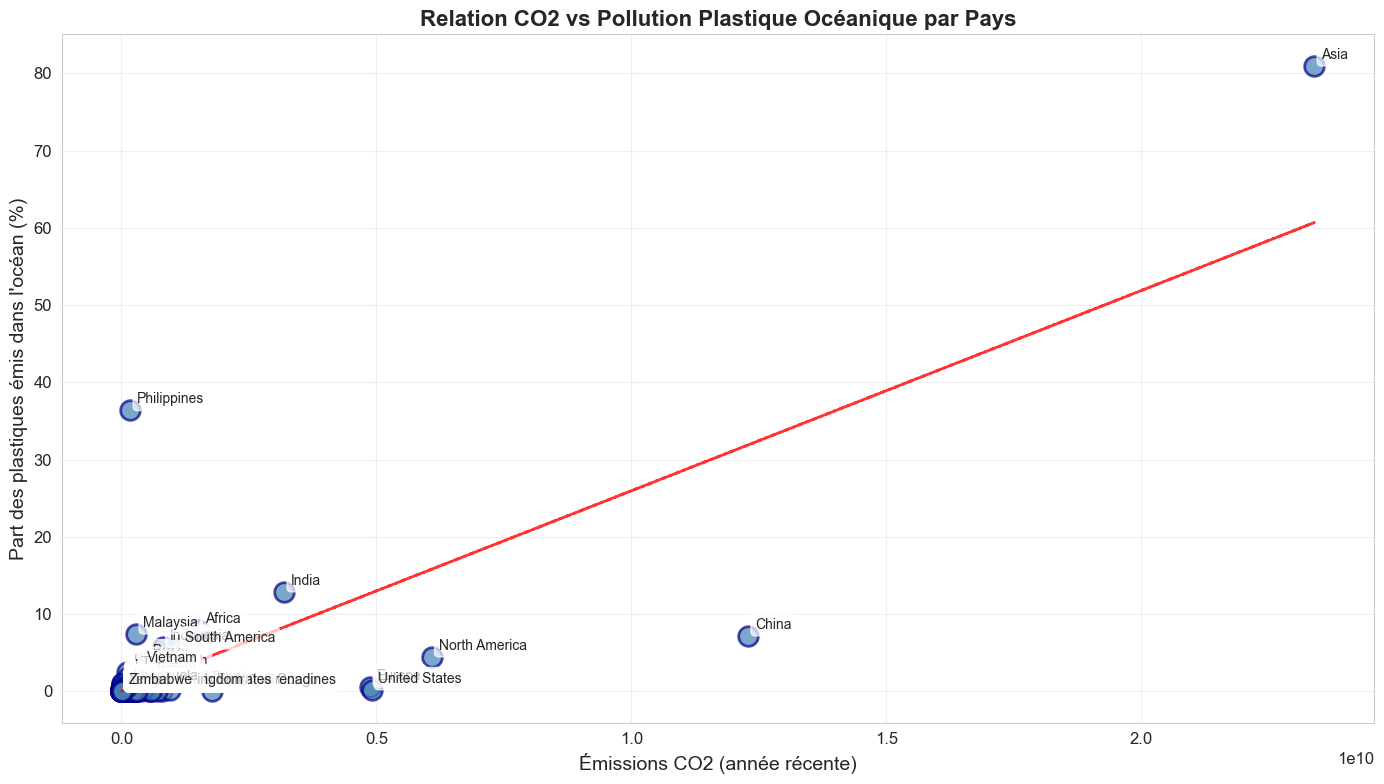


Corrélation CO2 vs pollution plastique océanique: 0.800 (p-value: 0.000)


In [40]:
fig, ax = plt.subplots(figsize=(14, 8))

scatter = ax.scatter(pollution_comparison['emissions_total'],
                    pollution_comparison['Share of global plastics emitted to ocean'],
                    s=200, alpha=0.7, c='steelblue', edgecolors='darkblue', linewidth=2)

# Ajouter les labels des pays
for i, row in pollution_comparison.iterrows():
    ax.annotate(row['Entity'],
               (row['emissions_total'], row['Share of global plastics emitted to ocean']),
               xytext=(5, 5), textcoords='offset points', fontsize=10,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Émissions CO2 (année récente)', fontsize=14)
ax.set_ylabel('Part des plastiques émis dans l\'océan (%)', fontsize=14)
ax.set_title('Relation CO2 vs Pollution Plastique Océanique par Pays',
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)

# Ligne de régression
z = np.polyfit(pollution_comparison['emissions_total'],
               pollution_comparison['Share of global plastics emitted to ocean'], 1)
p = np.poly1d(z)
ax.plot(pollution_comparison['emissions_total'], p(pollution_comparison['emissions_total']),
        "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

# Corrélation
if len(pollution_comparison) > 3:
    corr_co2_ocean = pearsonr(pollution_comparison['emissions_total'],
                             pollution_comparison['Share of global plastics emitted to ocean'])
    print(f"\nCorrélation CO2 vs pollution plastique océanique: {corr_co2_ocean[0]:.3f} (p-value: {corr_co2_ocean[1]:.3f})")


Pays avec données CO2 et importations plastique: 97


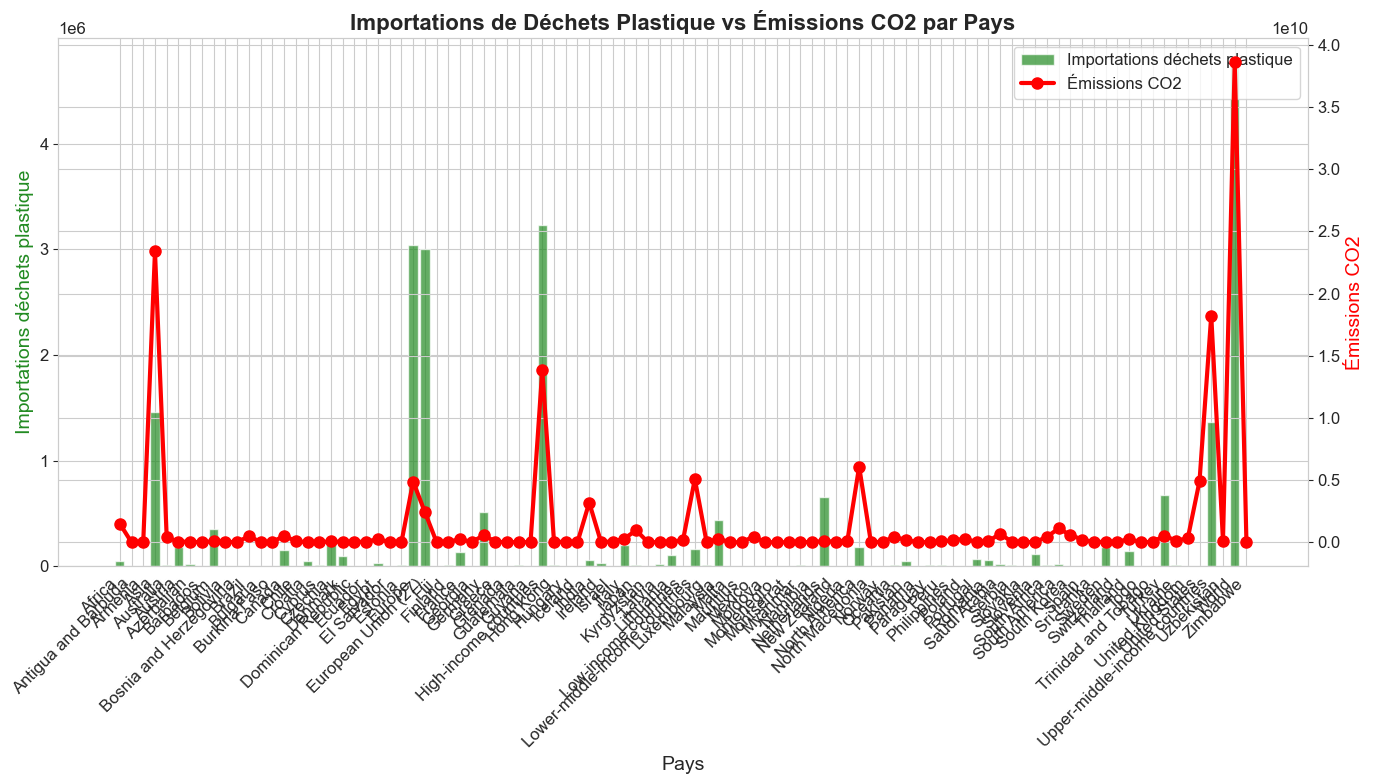


📦 Corrélation importations plastique vs CO2: 0.781 (p-value: 0.000)


In [50]:
if 'Imports of plastic waste via all modes of transport' in df_plastic_waste.columns:
    # Données récentes d'importation
    annee_recente_waste = df_plastic_waste['Year'].max()
    waste_recent = df_plastic_waste[df_plastic_waste['Year'] == annee_recente_waste]

    # Fusion avec CO2
    waste_co2_comparison = top_co2_pays[['Entity', 'emissions_total']].merge(
        waste_recent[['Entity', 'Imports of plastic waste via all modes of transport']],
        on='Entity', how='inner'
    )

    if len(waste_co2_comparison) > 0:
        print(f"Pays avec données CO2 et importations plastique: {waste_co2_comparison.shape[0]}")

        # Graphique
        fig, ax = plt.subplots(figsize=(14, 8))

        bars = ax.bar(range(len(waste_co2_comparison)),
                     waste_co2_comparison['Imports of plastic waste via all modes of transport'],
                     color='forestgreen', alpha=0.7, label='Importations déchets plastique')

        ax2 = ax.twinx()
        line = ax2.plot(range(len(waste_co2_comparison)),
                       waste_co2_comparison['emissions_total'],
                       color='red', marker='o', linewidth=3, markersize=8, label='Émissions CO2')

        ax.set_xlabel('Pays', fontsize=14)
        ax.set_ylabel('Importations déchets plastique', color='forestgreen', fontsize=14)
        ax2.set_ylabel('Émissions CO2', color='red', fontsize=14)

        ax.set_xticks(range(len(waste_co2_comparison)))
        ax.set_xticklabels(waste_co2_comparison['Entity'], rotation=45, ha='right')

        ax.set_title('Importations de Déchets Plastique vs Émissions CO2 par Pays',
                     fontsize=16, fontweight='bold')

        # Légende combinée
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        plt.tight_layout()
        plt.show()

        # Corrélation
        corr_waste_co2 = pearsonr(waste_co2_comparison['Imports of plastic waste via all modes of transport'],
                                 waste_co2_comparison['emissions_total'])
        print(f"\n📦 Corrélation importations plastique vs CO2: {corr_waste_co2[0]:.3f} (p-value: {corr_waste_co2[1]:.3f})")
